<h2> AUTHORS: Albin Larsson & Alex Wolf

In [45]:
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

In [46]:
import warnings
warnings.filterwarnings("ignore")

TASK 1: A classification example: fetal heart condition diagnosis

Step 1. Reading the data

In [47]:
# Read the CSV file.
data = pd.read_csv("CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

Step 2: Training a dummy classifier

In [48]:
dummyclassifier = DummyClassifier(strategy='most_frequent')

In [49]:
np.average(cross_val_score(dummyclassifier, Xtrain, Ytrain))

0.7805882352941176

Step 3: Trying out some different classifiers

Trying a basic tree:

In [50]:
decisiontree = DecisionTreeClassifier(random_state=0)

In [51]:
np.average(cross_val_score(decisiontree, Xtrain, Ytrain))

0.9241176470588235

Then we try an ensemble of decision trees:<br>
It seems like 4-5 is the most "bang for buck" depth (we just messed around with the depth parameter). WE used this to cross validate and take the average. Pretty good score!


In [68]:
randomforest = RandomForestClassifier(max_depth=5, random_state=0)

In [69]:
np.average(cross_val_score(randomforest, Xtrain, Ytrain))

0.9241176470588236

Gradient boosting testing:

In [70]:
gradientboosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                              max_depth=1, random_state=0).fit(Xtrain, Ytrain)

In [71]:
np.average(cross_val_score(gradientboosting, Xtrain, Ytrain))

0.9170588235294117

A single perceptron test:

In [72]:
perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(Xtrain, Ytrain)

Perceptron()

In [73]:
cross_val_score(perceptron, Xtrain, Ytrain)

array([0.84705882, 0.88529412, 0.82941176, 0.85294118, 0.71176471])

In [74]:
svc = make_pipeline(StandardScaler(),LinearSVC(dual="auto", random_state=0, tol=1e-5))
svc.fit(Xtrain, Ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(dual='auto', random_state=0, tol=1e-05))])

In [75]:
cross_val_score(svc, Xtrain, Ytrain)

array([0.88529412, 0.90882353, 0.86176471, 0.89705882, 0.90294118])

We select the random forest with our depth as 5 as we evaluated on the training set.

In [77]:
randomforest.fit(Xtrain, Ytrain)
Yguess = randomforest.predict(Xtest)
print(accuracy_score(Ytest, Yguess))

0.8990610328638498


As we can see above our 5 selected type of models has different scores on the cross validation. We chose to not tune too many hyperparameters (only some few) since it is an impossible job to select the perfect hyperparameters. We are happy with the selection given our limited time on this assignment. We chose the Random Forest as the "final" model because it had the highest cross validaton among the sample of models. Random forest is just an ensemble of decision trees but with additional things. It is trained on a subsamble of the training set (Bagging). It has some other hyperparameters but to not spend too much time on this assignment we selected Random Forest. The final accuracy is actually very high!

TASK 2: Decision trees for classification

In [79]:
data = pd.read_csv('iris.csv')
data_shuffled = data.sample(frac=1.0, random_state=0)
X = data_shuffled.drop('species', axis=1)
Y = data_shuffled['species']

In [80]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.4, random_state=0)

In [81]:
X2 = X[['petal_length', 'petal_width']]
Y_encoded = Y.replace({'setosa':0, 'versicolor':1, 'virginica':2})

In [82]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False
        
    def to_str(self, indent, lines, names):
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        lines.append(' '*indent + val_str)

In [83]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id
        
    def to_str(self, indent, lines, names):
        pad = ' '*indent
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lines.append(pad + f'{fname} <= {self.threshold:.3g}?')
        lines.append(pad + '  True =>')
        self.low_subtree.to_str(indent+4, lines, names)
        lines.append(pad + '  False =>')
        self.high_subtree.to_str(indent+4, lines, names)
        

In [84]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    #is used for regression trees as well
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)
        #regression the mean value is returned
        
        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        
        _, best_feature, best_threshold = \
            max(self.best_split(X, Y, feature) 
                for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = \
            self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    def __str__(self):
        lines = []
        self.root.to_str(0, lines, self.names)
        return '\n'.join(lines)
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [85]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


In [86]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

Check MSE as a function of depth to see which depth gives the best MSE

0.7 1
0.9555555555555555 2
0.9555555555555555 3
0.9555555555555555 4
0.9555555555555555 5
0.9555555555555555 6
0.9555555555555555 7
0.9555555555555555 8
0.9555555555555555 9
0.9555555555555555 10


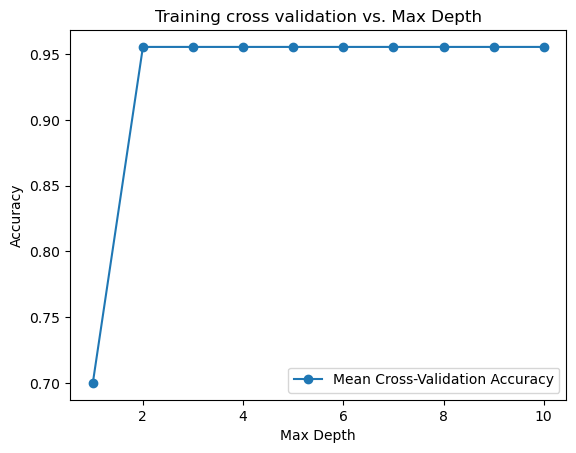

In [87]:
max_depths = range(1, 11) 

depths = []
cv_accuracies = []
test_accuracies = []

#loop through the different max_depths
for depth in max_depths:

    cls = TreeClassifier(max_depth=depth)
    cls.fit(Xtrain, Ytrain)

    cv_score = np.mean(cross_val_score(cls, Xtrain, Ytrain, cv=5))

    depths.append(depth)
    cv_accuracies.append(cv_score)
    print(cv_score, depth)

# Plot the results
plt.plot(depths, cv_accuracies, label='Mean Cross-Validation Accuracy', marker='o')
plt.title('Training cross validation vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Draw the final tree with 2 depth since the graph above reported that the best depth is 2. If we did 3 as depth we would probably overfit.
    

In [88]:
cls = TreeClassifier(max_depth=2)
cls.fit(Xtrain, Ytrain)
#cls.draw_tree()

In [89]:
predictions=cls.predict(Xtest)
print(predictions)

['virginica', 'virginica', 'virginica', 'setosa', 'versicolor', 'setosa', 'virginica', 'virginica', 'virginica', 'versicolor', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'virginica', 'setosa', 'virginica', 'versicolor', 'versicolor', 'virginica', 'versicolor', 'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'virginica', 'virginica', 'versicolor', 'versicolor', 'virginica', 'virginica', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'setosa', 'versicolor', 'setosa', 'virginica', 'versicolor', 'virginica', 'setosa', 'versicolor', 'versicolor', 'setosa', 'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica', 'setosa', 'virginica', 'versicolor', 'versicolor']


Final evaluation accuracy check for a tree with depth 2 on Test set

In [90]:
accuracy_score(Ytest, predictions)

0.9

Task 3: A regression example: predicting apartment prices

In [91]:
# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 7 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [92]:
m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.00217533, 0.00133681, 0.00150943, 0.00159287, 0.00232077]),
 'score_time': array([0.00103688, 0.00070143, 0.00079608, 0.00095153, 0.00103545]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

In [93]:
randomforest = RandomForestRegressor(max_depth=10, random_state=0)
randomforest.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=10, random_state=0)

In [94]:
cross_validate(randomforest, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([2.05226731, 2.0273335 , 2.05585861, 2.10945511, 2.0411787 ]),
 'score_time': array([0.03830481, 0.03791022, 0.03738856, 0.03933644, 0.03794098]),
 'test_score': array([-0.27916833, -0.25042886, -0.26385433, -0.27309293, -0.26307047])}

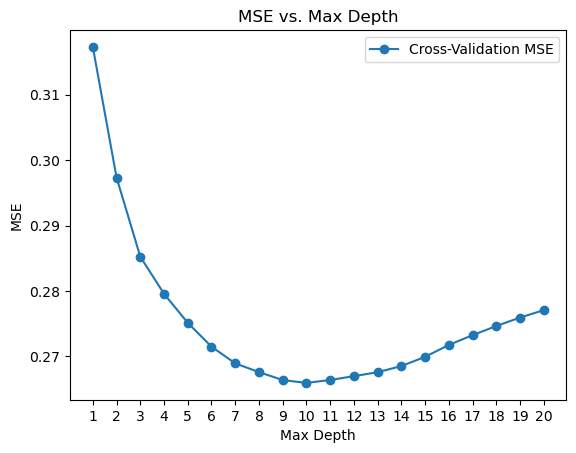

In [96]:
max_depths = range(1, 21)

depths = []
cv_mse = []

#different depths on the training data
for depth in max_depths:
    
    regressor = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=100, n_jobs=-1)
    
    #mean of MSE of each depth 
    cv_mse_score = -np.mean(cross_val_score(regressor, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error'))
    
    depths.append(depth)
    cv_mse.append(cv_mse_score)
    #print(f"Max Depth: {depth}, Cross-Validation MSE: {cv_mse_score}")

plt.plot(depths, cv_mse, label='Mean Cross-Validation MSE', marker='o')
plt.title('MSE vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.xticks(depths)
plt.legend()
plt.show()

We plot the Max depth of the random forst on MSE on the traning set. This graph gives us the MSE based on the Max Depth. This in turn is used to traing a final model which is then evaluated on the test set.

In [99]:
regressor_final = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100,
                                        n_jobs = -1)

In [100]:
from sklearn.metrics import mean_squared_error
  
regressor_final.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, regressor_final.predict(Xtest))

0.2740850405500036

We used the a random forest regressor model which that fits many decision tree regressors to get a better overall prediction.<br>
For this model the mean squared error is a good evaluation score where this model only has a mean squared error of approximately 0.27. As given by the above graph, we trained the model with Max Depth = 10.

TASK 4: Decision trees for regression

In [36]:
from collections import Counter
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):

    #define a threshold since that is a parameter within regressor tree
    def __init__(self, max_depth=10, threshold=1e-5):
        super().__init__(max_depth)
        self.threshold = threshold
        
    def fit(self, X, Y):
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))


    #return mean bc of continous data
    def get_default_value(self, Y):
        return np.mean(Y)
    

    def is_homogeneous(self, Y):
        return np.var(Y) < self.threshold
        
 
    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = X[sorted_indices, feature]
        Y_sorted = Y[sorted_indices]

        n = len(Y)

        #overall variance
        overall_var = np.var(Y)

        #Initialize variables to keep track of sum and sum 
        #of squares for lower and upper partitions
        sum_lower = 0
        sum_squares_lower = 0
        sum_upper = np.sum(Y)
        sum_squares_upper = np.sum(Y**2)

        #init variables
        max_score = -np.inf
        max_i = None

        #check all positions
        for i in range(0, n - 1):
            
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            #update sums and sum square lower and upper
            sum_lower += y_i
            sum_squares_lower += y_i**2
            sum_upper -= y_i
            sum_squares_upper -= y_i**2

            #if the input is equal to the input 
            #at the next position, we will not consider a split here.
            x_next = X_sorted[i + 1]
            if x_i == x_next:
                continue

            #formula
            var_reduction = overall_var - ((i + 1) / n) * (sum_squares_lower - (sum_lower**2) / (i + 1)) \
                            - ((n - i - 1) / n) * (sum_squares_upper - (sum_upper**2) / (n - i - 1))

            # If this is the best split, remember it.
            if var_reduction > max_score:
                max_score = var_reduction
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[max_i] + X_sorted[max_i + 1])
        return max_score, feature, split_point

Sanity check

In [37]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

Mean Squared Error on the test set: 0.007711453614317203


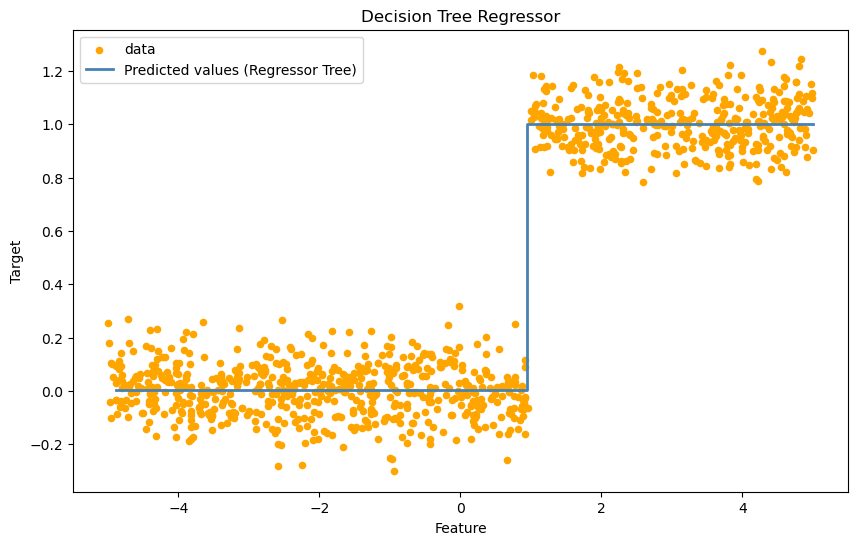

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate some data
np.random.seed(0)
n_samples = 1000
X, Y = make_some_data(n_samples)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create an instance of your TreeRegressor
tree_regressor = TreeRegressor(max_depth=1)

# Fit the model on the training data
tree_regressor.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = tree_regressor.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error on the test set: {mse}')
Y_pred = np.array(Y_pred)
# Sort the indices for plotting
sort_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sort_idx]
Y_pred_sorted = Y_pred[sort_idx]


# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, s=20, c="orange", label="data")
plt.step(X_test_sorted, Y_pred_sorted, where='mid', color="steelblue", lw=2, label="Predicted values (Regressor Tree)")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Decision Tree Regressor")
plt.legend()
plt.show()

A depth of one made the most sense since there are two distinct patches of data points. In other words 1 decision and two leaves. If we allow the tree to have a large number our model will overfit then which means our model fits well for the training data but not for unseen data.

Below we print the tree, but we will upload it seperately to canvas since we had issues exporting the whole notebook to PDF.
We dont really know why the tree graph made such error but please observe our two tree graphs in seperate PDFs

In [39]:
from graphviz import Source
#tree_regressor.draw_tree()

tree_regressor = tree_regressor.draw_tree()

# Save the tree as a PDF
tree_regressor.render('tree_regressor', format='pdf', cleanup=True)

'tree_regressor.pdf'

In [40]:
# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 7 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

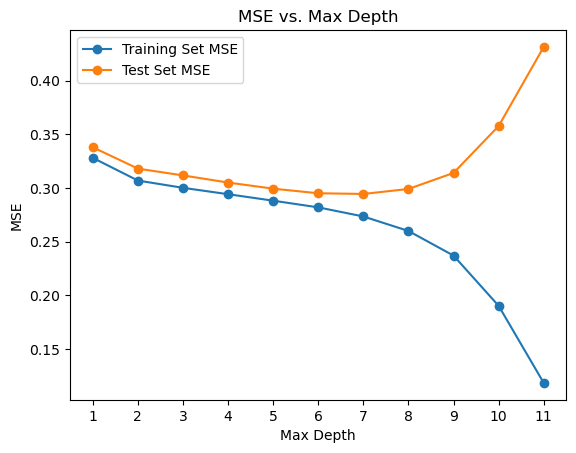

In [41]:
max_depths = range(1, 12)

# Lists to store results
depths = []
training_mse = []  # Change this from cv_mse to training_mse
test_mse = []

# Loop through different max depths
for depth in max_depths:
    # Create and train the regressor
    russian_regressor = TreeRegressor(max_depth=depth, threshold=0.01) 
    russian_regressor.fit(Xtrain, Ytrain)

    # Training set MSE
    predictions_train = russian_regressor.predict(Xtrain)
    training_mse_score = mean_squared_error(Ytrain, predictions_train)
    
    # Predictions on the test set
    predictions_test = russian_regressor.predict(Xtest)
    
    # MSE on the test set
    test_mse_score = mean_squared_error(Ytest, predictions_test)

    # Save results
    depths.append(depth)
    training_mse.append(training_mse_score)
    test_mse.append(test_mse_score)

# Plot the results
plt.plot(depths, training_mse, label='Training Set MSE', marker='o')
plt.plot(depths, test_mse, label='Test Set MSE', marker='o')
plt.title('MSE vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.xticks(depths)  
plt.legend()
plt.show()

Every point represents the mean squared error for the maximum (MSE) tree depth. The lines are close together until the tree grows to a depth of 6.<br>
The MSE gets lower for the training set because the model "memorizes" the training data whereas the MSE of the unseen data gets higher due to the "memorizing" and not finding trends which is called overfitting.

Below we print the tree, but we will upload it seperately to canvas since we had issues exporting the whole notebook to PDF.
We dont really know why the tree graph made such error but please observe our two tree graphs in seperate PDFs

In [42]:
# Drawing tree for russian apartment prices data with a depth of 4. Drawing anything bigger than 4 can't be properly drawn and 4 seems a good fit
rus_tree = TreeRegressor(max_depth=4, threshold=0.01)
rus_tree.fit(Xtrain, Ytrain)
#rus_tree.draw_tree()

rus_tree = rus_tree.draw_tree()

# Save the tree as a PDF
rus_tree.render('rus_tree', format='pdf', cleanup=True)

'rus_tree.pdf'